In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import keras
import random
import shutil
from matplotlib.image import imread
from pathlib import Path
import shutil
import random
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from google.colab import files


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,BatchNormalization,Dropout
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# 2. Setup Kaggle API credentials
# Upload file kaggle.json dari laptop
uploaded = files.upload()

# Ambil nama file yang diupload (biasanya key pertama di dict `uploaded`)
kaggle_file = list(uploaded.keys())[0]

# Buat folder .kaggle di direktori home
os.makedirs("/root/.kaggle", exist_ok=True)

# Pindahkan file kaggle.json ke folder yang sesuai
shutil.move(kaggle_file, "/root/.kaggle/kaggle.json")

# Set permission agar tidak error
os.chmod("/root/.kaggle/kaggle.json", 600)


Saving kaggle (2).json to kaggle (2).json


In [ ]:
# 3. Download dataset (contoh: fruits dataset dari Kaggle)
!kaggle datasets download -d mohamedchahed/dog-breeds

Dataset URL: https://www.kaggle.com/datasets/mohamedchahed/dog-breeds
License(s): CC0-1.0
100% 82.0M/82.3M [00:00<00:00, 844MB/s]
100% 82.3M/82.3M [00:00<00:00, 839MB/s]


In [ ]:
# 4. Unzip the dataset
import zipfile

with zipfile.ZipFile('dog-breeds.zip', 'r') as zip_ref:
    zip_ref.extractall('images')

print("Dataset berhasil diunduh dan diekstrak ke folder 'images'")



Dataset berhasil diunduh dan diekstrak ke folder 'images'


In [ ]:


def split_data(source_dir, train_dir, test_dir, val_dir, train_size=0.7, test_size=0.2, val_size=0.1):
    if not os.path.exists(train_dir): os.makedirs(train_dir)
    if not os.path.exists(test_dir): os.makedirs(test_dir)
    if not os.path.exists(val_dir): os.makedirs(val_dir)

    classes = os.listdir(source_dir)
    for cls in classes:
        cls_path = os.path.join(source_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        images = os.listdir(cls_path)
        random.shuffle(images)
        n_total = len(images)
        n_train = int(train_size * n_total)
        n_test = int(test_size * n_total)

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

        for i, img in enumerate(images):
            src = os.path.join(cls_path, img)
            if i < n_train:
                dst = os.path.join(train_dir, cls, img)
            elif i < n_train + n_test:
                dst = os.path.join(test_dir, cls, img)
            else:
                dst = os.path.join(val_dir, cls, img)
            shutil.copy2(src, dst)  # gunakan copy bukan symlink untuk Colab

# Contoh penggunaan
source_dir = os.path.join("images", "dog-breeds")
train_dir = os.path.join("images", "train")
test_dir = os.path.join("images", "test")
val_dir = os.path.join("images", "validation")

split_data(source_dir, train_dir, test_dir, val_dir)
print("✅ Dataset berhasil dibagi ke train/test/validation.")


✅ Dataset berhasil dibagi ke train/test/validation.


In [ ]:
# --- Step 3: Visualize random images from dataset ---
def visualize_random_image(target_dir, target_class):
    class_dir = os.path.join(target_dir, target_class)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    plt.show()

# Get class names from train folder
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

# Visualize random images from each class
for cls in class_names:
    visualize_random_image(train_dir, cls)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

Model = Sequential()

Model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(100, 100, 3)))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Conv2D(16, kernel_size=(3,3), padding='valid', activation='relu'))
Model.add(MaxPooling2D(pool_size=(2,2), strides=1, padding='valid'))

Model.add(Flatten())
Model.add(Dense(128, activation='relu'))

Model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Tampilkan shape
Model.summary()

# Callback untuk menghentikan training jika tidak membaik
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 97, 97, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 95, 95, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 94, 94, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 92, 92, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 91, 91, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 89, 89, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 86, 86, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 85, 85, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,796,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,931,825 (56.96 MB)

 Trainable params: 14,931,825 (56.96 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Step 4: Prepare datasets using ImageDataGenerator ---
IMG_SIZE = (240, 240)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 376 images belonging to 8 classes.
Found 106 images belonging to 8 classes.
Found 59 images belonging to 8 classes.


In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3), weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')  # 8 kelas
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# --- Step 5: Build CNN model ---
tf.random.set_seed(42)

model = Sequential([
    Conv2D(10, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(20, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(len(class_names), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 238, 238, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 119, 119, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 117, 117, 20)   │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 58, 58, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 67280)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │       538,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,348 (2.06 MB)

 Trainable params: 540,348 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Step 6: Train the model ---
EPOCHS = 20

history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=val_data,
    steps_per_epoch=len(train_data),
    validation_steps=len(val_data)
)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1714 - loss: 3.7737 - val_accuracy: 0.3559 - val_loss: 2.2306
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3750 - loss: 1.9529 - val_accuracy: 0.5424 - val_loss: 1.6879
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6541 - loss: 1.3630 - val_accuracy: 0.6102 - val_loss: 1.4057
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8033 - loss: 0.9099 - val_accuracy: 0.7458 - val_loss: 1.0060
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9086 - loss: 0.5036 - val_accuracy: 0.8305 - val_loss: 0.8214
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9717 - loss: 0.2524 - val_accuracy: 0.7966 - val_loss: 0.6947
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9955 - loss: 0.1119 - val_accuracy: 0.7627 - val_loss: 0.7083
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 1.0000 - loss: 0.0464 - val_accuracy: 0.8136 - val_loss:

In [ ]:

# --- Step 7: Evaluate the model ---
test_loss, test_acc = model.evaluate(test_data, steps=len(test_data))
print(f"Test Accuracy: {test_acc:.4f}")



In [ ]:
# --- Step 8: Plot learning curves ---


pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
import os
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

model_path = 'model_quantized-final-gazael.tflite'
with open(model_path, 'wb') as f:
    f.write(tflite_model)

size_in_bytes = os.path.getsize(model_path)
size_in_mb = size_in_bytes / 1024 / 1024

print(f"Quantized Model Size: {size_in_mb:.2f} MB")

Saved artifact at '/tmp/tmpwwd53ran'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135486118476880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118476112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118476496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118881488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118883408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118883984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118883792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118884176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118884368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135486118885520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13548779841134

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted class: rottweiler


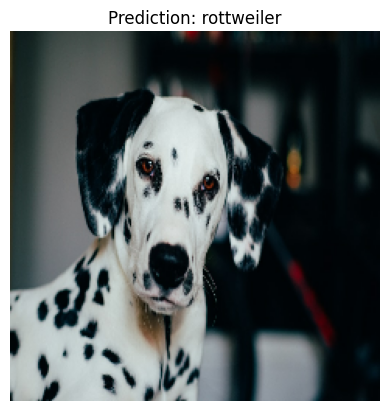

In [ ]:

# --- Step 9: Make a prediction on a new image ---
IMG_SIZE = (238, 238)

def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def predict_image(model, img_path, class_names):
    img = load_and_preprocess_image(img_path)
    img = tf.expand_dims(img, axis=0)
    preds = model.predict(img)
    pred_class = class_names[np.argmax(preds)]
    print(f"Predicted class: {pred_class}")
    plt.imshow(tf.squeeze(img))
    plt.title(f"Prediction: {pred_class}")
    plt.axis('off')
    plt.show()


# Example usage: replace 'banana.jpg' with your image path
image_path = '/content/images/dog-breeds/dalmatian/dalmatian12.jpg'
predict_image(model, image_path, class_names)
